In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from geopy.distance import distance,great_circle
from tqdm import tqdm

# Data

In [2]:
catalog = pd.read_csv('20020416-20220116.csv')

In [3]:
time_list = catalog.time.to_numpy()
times=[]
for tt in time_list:
    times.append(datetime.strptime(tt, '%Y-%m-%dT%H:%M:%S.%fZ'))
times=np.array(times)
latitudes = catalog.latitude.to_numpy()
longitudes = catalog.longitude.to_numpy()
magnitudes = catalog.mag.to_numpy()

## Nearest-Neighbor Proximity for Earthquakes

In [4]:
n = len(catalog)
eta = np.zeros((n,n)) # proximity matrix between event i and event j
t = np.zeros((n,n)) # time
r = np.zeros((n,n)) # lat

In [5]:
d = 1.3
w = 1

In [6]:
calculate_eta = False
if calculate_eta:
    for i in tqdm(range(n)):
        ti = times[i]
        ri = (latitudes[i],longitudes[i])
        mi = magnitudes[i]
        for j in range(n):
            tj = times[j]
            rj = (latitudes[j],longitudes[j])

            t[i,j] = (tj-ti).total_seconds()
            r[i,j] = great_circle(ri,rj).kilometers

            if t[i,j] > 0:
                eta[i,j] = t[i,j] * ( r[i,j] ** d ) * 10 ** (-w * mi)
            else:
                eta[i,j] = np.inf


##### eta_v1 uses w = 0, d = 1.5 as suggested by the Zaliapin & Ben-Zion (2020)

In [7]:
import pickle

# with open('eta_v1.pickle', 'wb') as file:
#     pickle.dump(eta, file, protocol=pickle.HIGHEST_PROTOCOL)

##### eta_v2 uses w = 1, d = 1.3 to recreate the results of Zaliapin and Ben-Zion (2016) 

In [8]:
# with open('eta_v2.pickle', 'wb') as file:
#     pickle.dump(eta, file, protocol=pickle.HIGHEST_PROTOCOL)

##### load eta pickle file

In [9]:
with open('eta_v2.pickle', 'rb') as file:
    eta = pickle.load(file)

In [10]:
df1 = pd.DataFrame(eta)

df1

,0,1,2,3,4,5,6,7,8,9,...,12566,12567,12568,12569,12570,12571,12572,12573,12574,12575
0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,2.938496e+03,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,1.725356e+04,4.068366e+04,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3,7.736212e+03,5.752877e+04,5.862524e+03,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,5.300807e+04,1.096999e+05,8.869675e+04,3.457414e+04,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12571,1.453274e+07,1.823040e+08,5.683663e+07,6.841654e+06,6.734843e+07,6.730603e+07,2.080353e+07,1.673765e+07,7.219820e+07,7.227955e+07,...,1.532805e+03,2.874750e+03,2.077008e+04,9.981077e+02,1.910520e+03,inf,inf,inf,inf,inf
12572,1.524041e+08,1.494527e+08,1.004028e+08,1.101283e+08,2.464390e+08,2.461243e+08,1.659382e+08,1.362268e+08,7.707981e+07,7.746577e+07,...,9.081773e+04,7.042089e+04,1.344924e+04,6.085256e+04,6.088584e+04,3.341993e+04,inf,inf,inf,inf
12573,3.008385e+07,2.586398e+07,9.089490e+06,2.054161e+07,3.671971e+07,3.678213e+07,3.176725e+07,1.964633e+07,2.736795e+07,2.744406e+07,...,1.788297e+04,1.423795e+04,1.591892e+03,1.090883e+04,1.244710e+04,6.594109e+03,105.731527,inf,inf,inf
12574,2.103770e+08,2.002869e+08,7.080470e+07,1.683999e+08,1.849609e+08,1.854296e+08,2.093873e+08,1.314001e+08,3.252884e+08,3.259932e+08,...,1.354590e+05,1.018615e+05,5.087209e+04,7.710262e+04,7.438650e+04,5.257069e+04,3711.820839,674.191633,inf,inf


In [11]:
nnd = np.zeros(n)
nnd_ind = np.zeros(n)

# i = nnd_ind[j] means that event i is the parent of event j
# the values in nnd_ind tells us the parent of event j
# the values in nnd tell us the distance between event j and its parent
    
for j in np.arange(1,n):
        nnd[j] = np.min(eta[j,0:j])
        nnd_ind[j] = np.argmin(eta[j,0:j])

In [12]:
nnd_ind[100]

83.0

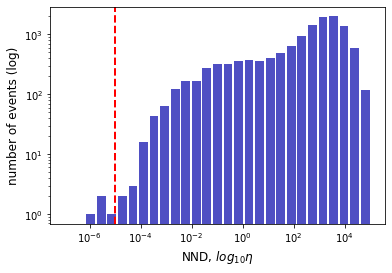

In [13]:
import matplotlib.pyplot as plt

bins = np.logspace(-7,5,30)
plt.xscale('log')
plt.hist(nnd, bins, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.yscale('log')
plt.axvline(x = 10**-5, linewidth = 2, linestyle ="--",
            color ='red')
plt.xlabel('NND, $log_{10}\eta$', fontsize = 12)
plt.ylabel("number of events (log)", fontsize = 12)
plt.show()

In [14]:
# # What is d? It is the slope of the histogram of r_ij

# x = np.arange(len(r.flatten()))

# plt.subplots()
# bins = np.logspace(-7,5,20)
# # plt.scatter(x, r.flatten())
# plt.hist(r.flatten(), bins, color='#0504aa', alpha=0.7, rwidth=0.85)
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

# Declustering Algorithm

1. look at scipy tree
2. write a recursive function to find children (depth first tree traversal)
3. embed in a loop over k to get a spanning forest


4. " This bimodality has been documented in multiple regions and on multiple scales (Gentili et al., 2017, 2019; Gu et al., 2013; Kossobokov & Nekrasova, 2017; Moradpour et al., 2014; Peresan & Gentili, 2018; Ruhl et al., 2016; Schoenball et al., 2015; Trugman et al., 2017; Vasylkivska & Huerta, 2017; Zaliapin & Ben-Zion, 2013a, 2013b, 2016a, 2016b). " look at these papers -- anything global?

5. look at zaliapin-zion global paper -- A Global Identification and characterization 
6. try breaking the clusters between by breaking at eta_0 = 10 ** -5

## Recursive function to find children

In [15]:
def children(nnd,nnd_ind, k,eta0,verbose=0):
    if verbose>1: print(f'Looking for children of event {k}:')
        
    # i = nnd_ind[j] means that event i is the parent of event j
    # the values in nnd_ind tells us the parent of event j
    # the values in nnd tell us the distance between event j and its parent
    
    # Find all children
    c = np.where(k == nnd_ind)[0]
    c = c[c!=0] # because event 0 is the parent of event 0
    
    # Limit to children that are close (eta < eta0)
    nearest_neighbor_distances_of_the_children = nnd[c]
    threshold = np.where(nearest_neighbor_distances_of_the_children < eta0)
    if verbose>1: print(f'Found {len(c)} potential children, and '+\
                      f'{len(c[threshold])} are close enough.')
    c = c[threshold]
    c = list(c)
    
    if len(c) == 0:
        if verbose>1: print('\tNo children')
        return []
    else:
        if verbose>0: print(f'\tFound {len(c)} children of {k}: {c}')
        new_c = []
        for i,x in enumerate(c):
            if verbose>1: print(f'\tLooking for grandchildren of {k} that are children of {x} '\
                              f'({i+1} out of {len(c)}):')
            grandchildren = children(nnd, nnd_ind, x,eta0,verbose=verbose)
            for gc in grandchildren:
                new_c.append(gc)

        # Don't modify c until we're outside of the loop
        for nc in new_c:
            c.append(nc)
            
    return c

In [51]:
from time import perf_counter
t0 = perf_counter()

n_clusters = 0
clusters = []
# an event can only be considered a children event if nearest-neigbor distance is < eta0
eta0 = 10**-3
nnd_ind_new = nnd_ind
spanning_forest = []
events_in_spanning_forest = []
verbose = 0


# while True:
    
for i in range(len(nnd)):
# for i in range(1000):
    
   # if len(nnd_ind_new) < 2: 
        # if verbose>0: print('All done')
      #  break
   # i = np.min(nnd_ind_new)
    
#     print(np.array(spanning_forest).flatten())
#     print(i)
#     print(' ')
#     print(f'{i} is in {events_in_spanning_forest}?  {np.isin(i,events_in_spanning_forest)}')
    if np.isin(i,events_in_spanning_forest):
        continue
    
    this_tree = children(nnd, nnd_ind, i,eta0,verbose=verbose)
    this_tree.append(i)
    for j in this_tree:
        events_in_spanning_forest.append(j)
    
    spanning_forest.append(this_tree)
    if len(this_tree)>1:
        if verbose>0: print(f'Cluster {n_clusters} has {len(this_tree)} events.')
        print(this_tree)
        clusters.append(np.array(this_tree))
        n_clusters = n_clusters + 1
    
    '''
    What is the biggest magnitude event in the list of events, this_tree?
    '''
   # We want to remove this_tree from nnd_ind_new 
   # nnd_ind_new = np.setdiff1d(nnd_ind_new, this_tree, assume_unique=True) # is this the issue? indexing?
    
   # if verbose>1: print(f'There are {len(nnd_ind_new)} events remaining.\n')


print(' ')
print(f'Runtime is {perf_counter()-t0}')
print(f'Number of clusters is {n_clusters}.')

[63, 64, 62]
[121, 120]
[299, 298]
[302, 301]
[306, 305]
[308, 307]
[340, 339]
[496, 495]
[584, 583]
[623, 622]
[688, 687]
[856, 857, 855]
[999, 998]
[1146, 1145]
[1369, 1368]
[1417, 1416]
[1554, 1553]
[1670, 1669]
[1841, 1838]
[1862, 1859]
[1874, 1873]
[2049, 2048]
[2096, 2095]
[2107, 2105]
[2611, 2610]
[2774, 2775, 2773]
[2917, 2916]
[2963, 2962]
[3206, 3205]
[3240, 3239]
[3707, 3703]
[3787, 3784]
[3835, 3834]
[3915, 3914]
[3924, 3923]
[3939, 3936]
[4213, 4212]
[4387, 4386]
[4391, 4390]
[4531, 4530]
[4561, 4558]
[4576, 4572]
[4594, 4593]
[4853, 4852]
[4896, 4895]
[4911, 4910]
[5239, 5225]
[5948, 5947]
[5956, 5955]
[6060, 6058]
[6192, 6191]
[6574, 6573]
[6598, 6590]
[6602, 6601]
[6618, 6613]
[6632, 6631]
[6750, 6749]
[6914, 6913]
[7038, 7037]
[7214, 7212]
[7278, 7277]
[7347, 7339]
[9707, 9708, 7415]
[7475, 7474]
[7519, 7518]
[7632, 7631]
[7672, 7668]
[7958, 7957]
[8192, 8191]
[8392, 8391]
[8446, 8444]
[8615, 8614]
[8711, 8710]
[8772, 8768]
[9056, 9053]
[9067, 9066]
[9307, 9306]
[9330,

In [ ]:
children(nnd,nnd_ind, 366, 10**-5, verbose=2)

In [ ]:
np.where(nnd_ind==366)

In [ ]:
# draw out trees!!!
# are we not correctly removing events after we find them?

In [ ]:
clusters

In [ ]:
len(nnd_ind_new)

In [ ]:
potential_clusters = np.where(nnd<1e-5)[0]

In [ ]:
i = 1
print (f'Event {i} has children:\n{np.where(nnd_ind==i)[0]} \n\nand corresponding NNDs:\n {nnd[np.where(nnd_ind==i)[0]]}')

In [ ]:
np.where(nnd_ind == potential_clusters[3])

In [ ]:
potential_clusters[3]